# Testing Out The PMF Estimator!
## Test 1
Can we predict just the distribution using a given wave int and depth? This should be a simple enough task but with very 
tiny number of data

In [59]:
from inverse_modelling_tfo.model_training.custom_models import PMFEstimatorNet
from pathlib import Path
import json
import pandas as pd



# Load the exp terms data
l4_dist_data_path = Path().resolve().parent.parent / "data" / "processed_data" / "l4_bins.pkl"
l4_dist_data = pd.read_pickle(l4_dist_data_path)
l4_dist_config_path = l4_dist_data_path.with_suffix('.json')
with open(l4_dist_config_path, 'r') as file:
    l4_dist_config = json.load(file)
chosen_detector_index = l4_dist_config['chosen_detector_index']

# Get the Feature Column names
l4_dist_columns = l4_dist_config['features']
l4_dist_columns = [str(x) for x in l4_dist_columns]

# The values do not add up to one because of thresholding - create a new excess column to account for this
l4_dist_data['excess'] = 1 - l4_dist_data[l4_dist_columns].sum(axis=1)
l4_dist_columns = l4_dist_columns + ['excess']

# Show
l4_dist_data.head()

,0.0,1.45708,2.7891,5.33881,10.21937,19.56159,37.44415,71.67437,137.19674,262.61751,Wave Int,Maternal Wall Thickness,excess
0,0.707548,0.005890,0.009654,0.014133,0.019081,0.024692,0.030225,0.035007,0.037641,0.037014,2,14,0.079115
1,0.414523,0.012100,0.020084,0.029892,0.041073,0.054029,0.066543,0.076601,0.079856,0.074127,2,8,0.131171
2,0.312103,0.013937,0.022342,0.032796,0.045969,0.061152,0.076766,0.089899,0.095177,0.088883,1,6,0.160975
3,0.767299,0.004674,0.007378,0.010559,0.014160,0.018154,0.022445,0.026212,0.028770,0.029018,1,16,0.071330
4,0.351096,0.013348,0.022004,0.032939,0.045684,0.060485,0.075219,0.086315,0.089818,0.082412,2,7,0.140680


## Creating The Network
We are going to create a network that predicts these distributions(named l4_dist_columns) using Wave Int and Maternal Wall Thickness

In [60]:
from model_trainer import ModelTrainer, RandomSplit, TorchLossWrapper, DataLoaderGenerator
import torch.nn as nn

x_columns = ['Wave Int', 'Maternal Wall Thickness']
y_columns = l4_dist_columns
print("X Columns: ", x_columns)
print("Y Columns: ", y_columns)
print("Input Length: ", len(x_columns))
print("Output Length: ", len(y_columns))
print("Total Data Length: ", len(l4_dist_data))

model = PMFEstimatorNet([len(x_columns), 5, len(y_columns)], [0.5, 0.5])
criterion = TorchLossWrapper(nn.MSELoss(), name='MSE')
validation_method = RandomSplit(0.7)
datagen = DataLoaderGenerator(l4_dist_data, x_columns, y_columns, batch_size=4)

trainer = ModelTrainer(model, datagen, validation_method, criterion)

X Columns:  ['Wave Int', 'Maternal Wall Thickness']
Y Columns:  ['0.0', '1.45708', '2.7891', '5.33881', '10.21937', '19.56159', '37.44415', '71.67437', '137.19674', '262.61751', 'excess']
Input Length:  2
Output Length:  11
Total Data Length:  62


In [61]:
from torch.optim import SGD
trainer.set_optimizer(SGD, {'lr': 1e-4, 'momentum': 0.86, 'nesterov': True})
trainer.run(100)

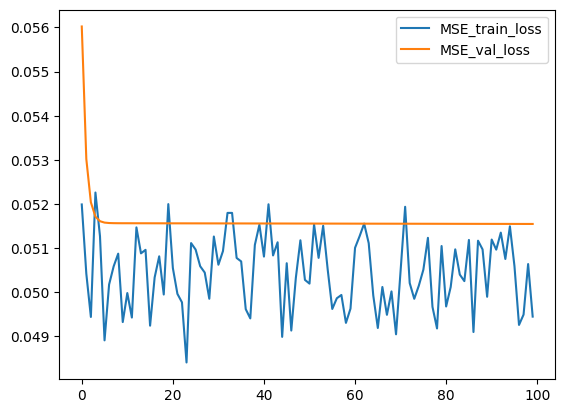

In [62]:
criterion.loss_tracker.plot_losses()

## Test 2
Can we make the same PMF predictions when we are given the intensity values(At a single wavelength) rather than the depth.
The intensity should, in theory, contain the depth information. But slightly more convoluted. 

In [63]:
# Load the log intensity data
i1_and_i2_data_path = Path().resolve().parent.parent / "data" / "processed_data" / "I1_and_I2_interp.pkl"
i1_and_i2 = pd.read_pickle(i1_and_i2_data_path)
i1_and_i2_config_path = i1_and_i2_data_path.with_suffix('.json')
with open(i1_and_i2_config_path, 'r') as file:
    i1_and_i2_config = json.load(file)
intensity_columns = i1_and_i2_config['features']